In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from attgcn_api import ATTGCN_API
import numpy as np
import matplotlib.pyplot as plt
from py_utils.TSP_loader import TSP_loader
from py_utils.TSP_utils import TSP_plotter
from py_utils.TSP_transformer import TSP_EucTransformer
import torch

In [10]:
x = [1,2]
y = x
x.append(1)
y

[1, 2, 1]

In [5]:
x = np.reshape(np.array([[1,2],[1,2]]), [1,1,2,2])
np.tile(x, (1,2,1,1)).shape

(1, 2, 2, 2)

In [7]:
np.expand_dims(x, axis=1).shape

(1, 1, 1, 2, 2)

In [96]:
def create_dir(save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

In [97]:

gcn_api = ATTGCN_API()
gcn_api.init_net()
gcn_api.load_ckpt()
gcn_api.clear_gpu_memory()

Using CUDA!


In [3]:
NUM_NODES = 20
n_graphs = 1000
path = f'./data/valid_sets'
# folder = f'synthetic_nrange_{NUM_NODES}_{NUM_NODES}_{n_graphs}'
folder = f'synthetic_n_{NUM_NODES}_{n_graphs}'

In [5]:
NUM_NODES = 50
n_graphs = 1000
path = f'./data/test_sets'
folder = f'synthetic_n_{NUM_NODES}_{n_graphs}'

In [7]:
NUM_NODES = 20
n_graphs = 200000
path = f'./data/train_sets'
folder = f'synthetic_n_{NUM_NODES}_{n_graphs}'

In [4]:
tsp_loader = TSP_loader()

In [5]:
g_list = tsp_loader.load_multi_tsp_as_nx(data_dir=f'{path}/{folder}', scale_factor=0.000001, start_index=0)

100%|██████████| 1000/1000 [00:06<00:00, 154.28it/s]


In [35]:
np.concatenate((np.array([[[1]]]),np.array([[[2]]])),-1) @ np.array([[1,2],[1,2]])

array([[[3, 6]]])

In [6]:
def load_tsp_solution(sol_filepath):
    solutions = []
    for line in open(sol_filepath):
        solution = line.split(':')[-1].strip(' ').strip('\n').strip('[]')
        solution.replace(' ', '')
        solution = [int(node) for node in solution.split(',')]
        solutions.append(solution)
    return solutions

In [24]:
np.arange(0,360,45)

array([  0,  45,  90, 135, 180, 225, 270, 315])

[(0, 16), (16, 17), (17, 3), (3, 13), (13, 14), (14, 7), (7, 1), (1, 19), (19, 9), (9, 12), (12, 4), (4, 5), (5, 6), (6, 10), (10, 8), (8, 2), (2, 11), (11, 18), (18, 15), (15, 0)]


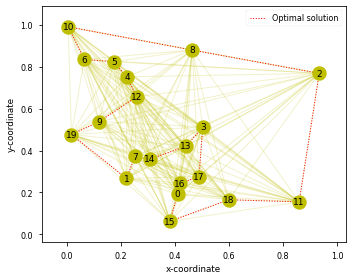

In [7]:
index = 0
graph = g_list[index]
all_solutions = load_tsp_solution(sol_filepath=f'{path}/{folder}/solutions.txt')
solution = all_solutions[index]
tsp_plotter = TSP_plotter()
tsp_plotter.plot_nx_graph(graph, solution=solution, edge_probs=None, save_path=None)

In [21]:
transformer = TSP_EucTransformer()

In [58]:
transformer.load_TSPs_from_nx(g_list[0:100])

[(0, 16), (16, 17), (17, 3), (3, 13), (13, 14), (14, 7), (7, 1), (1, 19), (19, 9), (9, 12), (12, 4), (4, 5), (5, 6), (6, 10), (10, 8), (8, 2), (2, 11), (11, 18), (18, 15), (15, 0)]


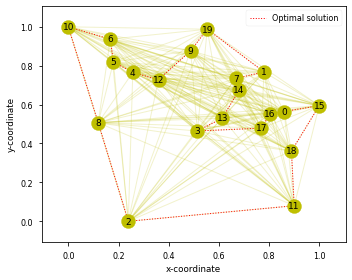

In [59]:
transformer.apply_random_transfo()
graph_list = transformer.save_TSP_as_nx()

tsp_plotter.plot_nx_graph(graph_list[index], solution=solution, edge_probs=None, save_path=None)


In [128]:
g_list = tsp_loader.load_multi_tsp_as_nx(data_dir=f'{path}/{folder}', scale_factor=0.000001, start_index=0)


100%|██████████| 1000/1000 [00:05<00:00, 167.62it/s]


In [129]:
gcn_api.load_nx_test_set(graph_list=g_list[0:100], num_nodes=NUM_NODES)
result_ = gcn_api.run_test(batch_size=100)

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


In [130]:
def prepare_heatmap(raw_heatmap):
    heat_map = np.maximum(raw_heatmap, raw_heatmap.transpose())
    np.fill_diagonal(heat_map, 0)
    heat_map[heat_map < 10**(-10)] = 0.0
    return heat_map

In [134]:
def get_heatmap_statistics(heatmap, solution):
    heatmap = prepare_heatmap(heatmap)
    probable_edgelist = np.transpose(np.where(np.triu(heatmap) > 0))
    # probable_edgelist = np.transpose(np.array(np.where(np.tril(heatmap) > 10**(-10))))
    probable_edgelist = [list(edge) for edge in probable_edgelist]
    probable_edge_score = np.sum(heatmap) / 2
    tour_edges = list(zip(solution, solution[1:]))
    tour_edges.append((solution[-1], solution[0]))
    present_edges = 0
    tour_edge_score = 0
    for edge in tour_edges:
        if list(edge) in probable_edgelist or list(edge)[::-1] in probable_edgelist:
            present_edges += 1
            tour_edge_score += heatmap[edge[0],edge[1]]
        else:
            pass
    probable_edge_ratio = present_edges/len(tour_edges)
    num_probable_edges = len(probable_edgelist)
    return probable_edge_ratio, num_probable_edges, tour_edge_score, probable_edge_score

In [246]:
def rate_heatmap(heatmap, solution):
    probable_edge_ratio, num_probable_edges, tour_edge_score, probable_edge_score = get_heatmap_statistics(heatmap, solution)
    if probable_edge_ratio < 1:
        rating = 0
    else:
        bad_edge_score = probable_edge_score - tour_edge_score
        num_nodes = heatmap.shape[0]
        rating = tour_edge_score / (bad_edge_score + num_nodes*0.5)
        # rating = tour_edge_score / probable_edge_score
    return rating, num_probable_edges

In [242]:
index = 2
print(np.max(result_[index]))
rate_heatmap(result_[index], all_solutions[index])

0.5008861216919912


0.9421283212839189

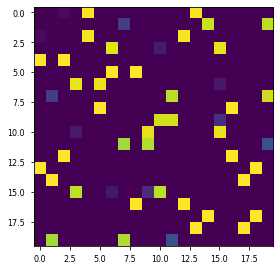

In [243]:
fig, ax = plt.subplots()
im = ax.imshow(result_[index])

In [224]:
def transform_graphs(g_list, axis=0):
    transfo = TSP_EucTransformer()
    test_list = []
    for g in g_list:
        transfo.load_TSP_from_nx(g)
        transfo.reflect_TSP(axis=1)
        # transfo.flip_TSP_coordinates()
        # transfo.rotate_TSP(degree=45)
        # transfo.apply_PCA_to_TSP()
        graph = transfo.save_TSP_as_nx()
        test_list.append(graph)
    return test_list

In [248]:

for i in range(5):
    if i == 0:
        gcn_api.load_nx_test_set(graph_list=g_list[0:100], num_nodes=NUM_NODES)
        result = gcn_api.run_test(batch_size=100)
        final_result = result
    else:
        test_list = transform_graphs(g_list[0:100], axis=i-1)
        gcn_api.load_nx_test_set(graph_list=test_list, num_nodes=NUM_NODES)
        result = gcn_api.run_test(batch_size=100)
        final_result = np.maximum(final_result, result)


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


In [ ]:
for index in range(100):
    orig_rating, orig_num_probable_edges = rate_heatmap(result_[index], all_solutions[index])
    rating, num_probable_edges = rate_heatmap(result[index], all_solutions[index])


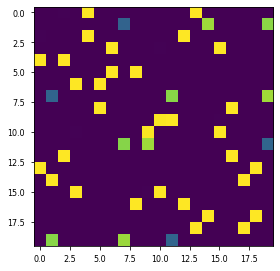

In [245]:
fig, ax = plt.subplots()
im = ax.imshow(result[index])

In [9]:
g_list = tsp_loader.load_multi_tsp_as_nx(data_dir=f'{path}/{folder}', scale_factor=0.000001, start_index=0)
gcn_api.load_nx_test_set(graph_list=g_list, num_nodes=NUM_NODES)
result = gcn_api.run_test(batch_size=100)
save_path = f'{path}/{folder}/heatmaps'
create_dir(save_path)
file_name = f'{folder}_heatmaps.npy'
np.save(file=f'{save_path}/{file_name}', arr=np.array(result))

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


In [8]:
for i in range(200):
    g_list = tsp_loader.load_multi_tsp_as_nx(data_dir=f'{path}/{folder}', scale_factor=10**(-6), start_index=i*1000, end_index=(i+1)*1000)
    gcn_api.load_nx_test_set(graph_list=g_list, num_nodes=20)
    result = gcn_api.run_test(batch_size=250)
    save_path = f'{path}/{folder}/heatmaps'
    create_dir(save_path)
    t = i * 1000
    file_name = f'{folder}_heatmaps_{t}-{t+1000}.npy'
    np.save(file=f'{save_path}/{file_name}', arr=np.array(result))

100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


# Analyze heatmaps

## Load heatmaps

In [11]:
import re
# load heatmaps and graphs
# combine both into graphic
# add tsp plotter function
def load_heatmaps(path, start_index, end_index):
    atoi = lambda text : int(text) if text.isdigit() else text
    natural_keys = lambda text : [atoi(c) for c in re.split('(\d+)', text)]
    try:
        fnames = [f for f in os.listdir(path) if os.path.isfile(f'{path}/{f}')]
        fnames.sort(key=natural_keys)
    except:
        print('\nBad heatmap directory!')
        return None
    if len(fnames) == 1:
        return np.load(f'{path}/{fnames[0]}')
    heat_maps = None
    for k, fname in enumerate(fnames):
        maps_start_index = int(fname.split('.')[0].split('-')[0].split('_')[-1])
        maps_end_index = int(fname.split('.')[0].split('-')[-1])
        index_diff = maps_end_index - maps_start_index
        if maps_end_index - 1 < start_index :
            continue
        if maps_start_index > end_index:
            continue
        cur_start_index = start_index - maps_start_index
        cur_end_index = np.minimum(index_diff, end_index - maps_start_index)

        if heat_maps is not None:
            heat_maps = np.concatenate([heat_maps, np.load(f'{path}/{fname}')[cur_start_index:cur_end_index]], axis=0)
        else:
            heat_maps = np.load(f'{path}/{fname}')[cur_start_index:cur_end_index]
    return heat_maps

In [6]:
path = 'data/train_sets/synthetic_n_20_50000'
heatmap_path = f'{path}/heatmaps'
start_index = 0
end_index = 10000

In [12]:
path = 'data/valid_sets/synthetic_n_20_1000'
heatmap_path = f'{path}/heatmaps'
start_index = 0
end_index = 10000

In [51]:
path = 'data/test_sets/synthetic_n_50_1000'
heatmap_path = f'{path}/heatmaps'
start_index = 0
end_index = 10000

In [13]:
heat_maps = load_heatmaps(heatmap_path, start_index, end_index)
tsp_loader = TSP_loader()
g_list = tsp_loader.load_multi_tsp_as_nx(data_dir=f'{path}', scale_factor=0.000001, start_index=start_index, end_index=end_index)

100%|██████████| 1000/1000 [00:06<00:00, 165.64it/s]


In [14]:
def load_tsp_solution(sol_filepath):
    solutions = []
    for line in open(sol_filepath):
        solution = line.split(':')[-1].strip(' ').strip('\n').strip('[]')
        solution.replace(' ', '')
        solution = [int(node) for node in solution.split(',')]
        solutions.append(solution)
    return solutions

In [15]:
all_solutions = load_tsp_solution(sol_filepath=f'{path}/solutions.txt')
len(all_solutions)
end_index = np.minimum(len(all_solutions), end_index)


In [16]:
def prepare_heatmap(raw_heatmap):
    heat_map = np.maximum(raw_heatmap, raw_heatmap.transpose())
    np.fill_diagonal(heat_map, 0)
    heat_map[heat_map < 10**(-10)] = 0.0
    return heat_map

In [17]:
num_probable_edges = []
edge_presence_rates = []
num_probable_edges_ = []
for i in range(end_index):
    heat_map = prepare_heatmap(heat_maps[i])
    probable_edgelist = np.transpose(np.where(np.triu(heat_map) > 0))
    # probable_edgelist = np.transpose(np.array(np.where(np.tril(heat_map) > 10**(-10))))
    probable_edgelist = [list(edge) for edge in probable_edgelist]
    solution = all_solutions[i]
    tour_edges = list(zip(solution, solution[1:]))
    tour_edges.append((solution[-1], solution[0]))
    present_edges = 0
    for edge in tour_edges:
        if list(edge) in probable_edgelist:
            present_edges += 1
        elif list(edge)[::-1] in probable_edgelist:
            present_edges += 1
        else:
            # print(edge)
            # print(probable_edgelist)
            pass
    edge_presence_rates.append(present_edges/len(tour_edges))
    num_probable_edges.append(len(probable_edgelist))
    num_probable_edges_.append(np.count_nonzero(heat_map)/2)



In [18]:
print("Percentage of contained optimal edges:", np.mean(edge_presence_rates))
print("Mean number of probable edges per graph:", np.mean(num_probable_edges))
print("Mean number of probable edges per graph:", np.mean(num_probable_edges_))
print("Max number of probable edges:", np.max(num_probable_edges))
print("Min number of probable edges", np.min(num_probable_edges))

Percentage of contained optimal edges: 1.0
Mean number of probable edges per graph: 33.063
Mean number of probable edges per graph: 33.063
Max number of probable edges: 77
Min number of probable edges 20


In [75]:
len(list(np.where(np.array([0,2,3,4,5,0,0,0]) == 0)))

1

[0, 5, 16, 4, 17, 9, 19, 13, 18, 10, 8, 3, 7, 6, 1, 14, 2, 11, 15, 12]
[(0, 5), (5, 16), (16, 4), (4, 17), (17, 9), (9, 19), (19, 13), (13, 18), (18, 10), (10, 8), (8, 3), (3, 7), (7, 6), (6, 1), (1, 14), (14, 2), (2, 11), (11, 15), (15, 12), (12, 0)]


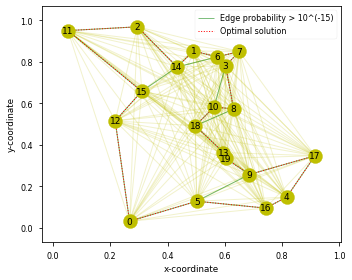

In [22]:
index = 20
heat_map = prepare_heatmap(heat_maps[index])
solution = all_solutions[index]
print(solution)
tsp_plotter = TSP_plotter()
tsp_plotter.plot_nx_graph(g_list[index], solution=solution, edge_probs=heat_map, save_path='plots/edge_probability_test.png')